In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import os
from torch.utils.data import DataLoader,Dataset
import scipy
from PIL import Image

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

In [3]:
class OxfordCustomDataset(Dataset):
    def __init__(self, img_dir, label_file, split_file, transform, split='train'):
        super().__init__()
        self.img_dir = img_dir
        self.transform = transform


        labels = scipy.io.loadmat(label_file)['labels'][0]
        self.labels = labels - 1

        setid = scipy.io.loadmat(split_file)
        if split == 'train':
            self.indices = setid['tstid'][0]
        elif split == 'val':
            self.indices = setid['valid'][0]
        elif split == 'test':
            self.indices = setid['trnid'][0]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        image_id = self.indices[index]
        label = self.labels[image_id - 1]
        image_path = os.path.join(self.img_dir, f'image_{image_id:05d}.jpg')
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
train_dataset_oxford = OxfordCustomDataset(
    img_dir="oxford/jpg/",
    label_file="oxford/imagelabels.mat",
    split_file="oxford/setid.mat",
    transform=transform,
    split="train"
)

test_dataset_oxford = OxfordCustomDataset(
    img_dir="oxford/jpg/",
    label_file="oxford/imagelabels.mat",
    split_file="oxford/setid.mat",
    transform=transform,
    split="test"
)

val_dataset_oxford = OxfordCustomDataset(
    img_dir="oxford/jpg/",
    label_file="oxford/imagelabels.mat",
    split_file="oxford/setid.mat",
    transform=transform,
    split="val"
)


In [101]:
train_data_loader = DataLoader(train_dataset_oxford,batch_size=64,shuffle=True)
test_data_loader = DataLoader(test_dataset_oxford,batch_size=1,shuffle=True)
val_data_loader = DataLoader(val_dataset_oxford,batch_size=64,shuffle=True)

In [47]:
model = models.googlenet(pretrained=True)

/Users/boss_07/Documents/statistics/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
model.parameters

<bound method Module.parameters of GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.00

In [49]:


for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 102)

for param in model.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "inception5" in name or "inception4" in name or "fc" in name:
        param.requires_grad = True


model = model.to("mps" if torch.mps.is_available() else "cpu")

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},                  # Last layer
    {'params': [param for name, param in model.named_parameters() 
                if param.requires_grad and "fc" not in name], 'lr': 1e-4}  # Fine-tuned layers
])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
device = "mps" if torch.mps.is_available() else "cpu"
if device == "mps":
    print("Using Apple Silicon GPU (MPS) for training.")
else:
    print("Using CPU for training.") 
num_epochs = 10
train_losses = []
val_losses = []
best_val_loss = float('inf') # Initialize best validation loss

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_data_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

In [52]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [53]:
evaluate(model, test_data_loader)

Accuracy: 93.73%


In [54]:
import matplotlib.pyplot as plt

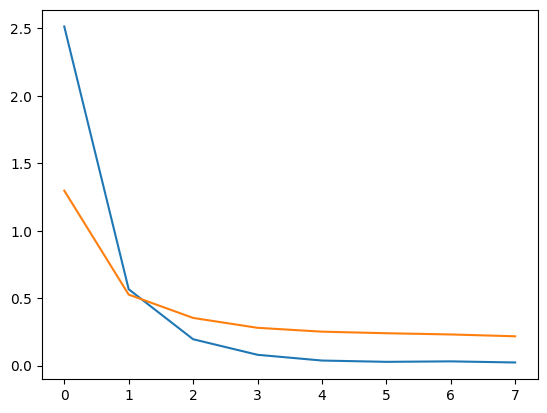

In [55]:
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:

torch.save(model.state_dict(), './models/googlenet_oxford.pth')
torch.save(model, './models/googlenet_oxford_full.pth')

In [ ]:

loaded_model = models.googlenet(aux_logits=False)
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 102)
loaded_model.load_state_dict(torch.load('./models/googlenet_oxford.pth'))
loaded_model = loaded_model.to(device)
loaded_model.eval()
evaluate(loaded_model, test_data_loader)

/Users/boss_07/Documents/statistics/.venv/lib/python3.12/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Accuracy: 82.25%


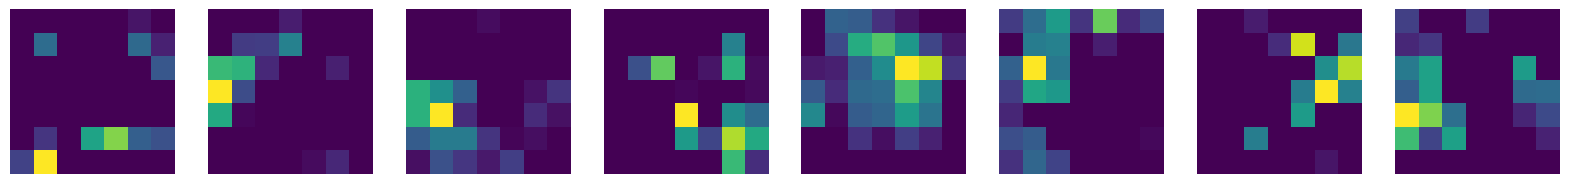

In [ ]:
activation = {}

def hook_fn(module, input, output):
    activation['value'] = output

last_conv_layer = loaded_model.conv1
last_conv_layer.register_forward_hook(hook_fn)
def visualize_activations(model, loader):
    model.eval()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        act = activation['value'].cpu().data.numpy()
        
        fig, axes = plt.subplots(1, 8, figsize=(20, 5))
        for i in range(8):
            ax = axes[i]
            ax.imshow(act[0, i], cmap='viridis')
            ax.axis('off')
        plt.show()
        break  # Visualize only the first batch
visualize_activations(loaded_model, test_data_loader)

In [94]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open("image.png").convert("RGB")
input_tensor = transform(img).unsqueeze(0)

In [95]:
model.eval()
with torch.no_grad():
    output = model(input_tensor.to(next(model.parameters()).device))